# Importing all required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import folium
from datetime import datetime

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [3]:
pd.__version__

'1.1.5'

In [4]:
df=pd.read_excel('time-series-data.xlsx')

# Data cleaning and preprocessing

In [5]:
df=df.sort_values(by='Date', ascending=True)
df.head()


,Country,Localite,Category,Value,Date
46857,Guinea,National,Suspected Cases,9,1900-01-04
46887,Guinea,National,Probable cases,337,1900-01-04
46977,Guinea,National,Deaths,1926,1900-01-04
0,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Cases,86,2014-03-24
1,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Deaths,59,2014-03-24


In [6]:
df=df[df.Date !='1900-01-04' ]   # Removing 1900-01-04 which is wrong.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58632 entries, 0 to 58634
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Country   58632 non-null  object        
 1   Localite  58632 non-null  object        
 2   Category  58632 non-null  object        
 3   Value     58214 non-null  object        
 4   Date      58632 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 2.7+ MB


In [8]:
df.shape

(58632, 5)

In [9]:
df['Value']=pd.to_numeric(df['Value'],errors='coerce')

In [10]:
df.isna().sum()

Country       0
Localite      0
Category      0
Value       425
Date          0
dtype: int64

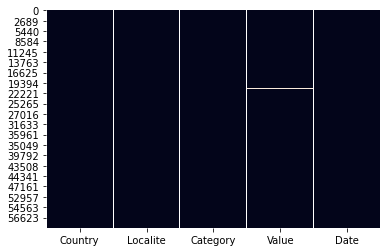

In [11]:
sns.heatmap(df.isnull(), cbar=False)

In [12]:
df=df.dropna(subset=['Value'])

In [13]:
df.shape

(58207, 5)

In [14]:
df['Value'].dtypes

dtype('float64')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58207 entries, 0 to 58634
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Country   58207 non-null  object        
 1   Localite  58207 non-null  object        
 2   Category  58207 non-null  object        
 3   Value     58207 non-null  float64       
 4   Date      58207 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.7+ MB


In [16]:
# df['Year']=df.Date.dt.year
# df['Month_name']=df.Date.dt.month_name()
# df['Day_name']=df.Date.dt.day_name()
# df['Month']=df.Date.dt.month
# df['Week']=df.Date.dt.week
# df['Day_of_year']= df.Date.dt.dayofyear



In [17]:
df.Category.unique()

array(['Cases', 'Deaths', 'Suspected cases', 'Confirmed cases',
       'Probable cases', 'New cases', 'Suspected Cases', 'New Cases'],
      dtype=object)

In [18]:
di={'Suspected cases':'Suspected Cases','New cases':'New Cases'}
df=df.replace({"Category":di})

In [18]:
df1=df[df.Localite != 'National']

In [19]:
df_1= pd.pivot_table(df1,values='Value',columns='Category',index=['Date','Country','Localite'],fill_value=0).reset_index()

In [20]:
df_1['Recovered']=(df_1['Cases']-df_1['Deaths']).abs()

In [21]:
df_1.tail(5)


Category,Date,Country,Localite,Cases,Confirmed cases,Deaths,New Cases,Probable cases,Suspected Cases,Recovered
9476,2015-03-28,Sierra Leone,Port,1923.0,1440.0,624.0,0.0,2.0,481.0,1299.0
9477,2015-03-28,Sierra Leone,Pujehun,63.0,31.0,21.0,0.0,2.0,30.0,42.0
9478,2015-03-28,Sierra Leone,Tonkolili,571.0,454.0,185.0,0.0,25.0,92.0,386.0
9479,2015-03-28,Sierra Leone,Western area rural,1545.0,1163.0,520.0,0.0,2.0,380.0,1025.0
9480,2015-03-28,Sierra Leone,Western area urban,3034.0,2224.0,763.0,2.0,5.0,805.0,2271.0


In [22]:
df_1.groupby('Country')['Cases','Deaths','Recovered'].sum()


C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Category,Cases,Deaths,Recovered
Country,,,
Guinea,363349.5,230414.0,133299.5
Liberia,843783.0,375444.0,471723.0
Mali,52.0,42.0,10.0
Nigeria,460.0,168.0,292.0
Senegal,19.0,0.0,19.0
Sierra Leone,1367120.0,424962.0,948612.0


In [23]:
print('The data is from :',df_1.Date.min(), 'to', df_1.Date.max())

print('The total number of Cases is', df_1['Cases'].sum())
print('The total number of Confirmed Cases is', df_1['Confirmed cases'].sum())
print('The total number of Deaths is', df_1['Deaths'].sum())
print('The total number of Probable cases is', df_1['Probable cases'].sum())
print('The total number of Suspected Cases is', df_1['Suspected Cases'].sum())
print('The total number of Recovery is', df_1['Recovered'].sum())


The data is from : 2014-03-24 00:00:00 to 2015-03-28 00:00:00
The total number of Cases is 2574783.5
The total number of Confirmed Cases is 1645143.264
The total number of Deaths is 1031030.0
The total number of Probable cases is 290417.5
The total number of Suspected Cases is 590281.0
The total number of Recovery is 1553955.5


# Top 3 Countries with the highest number of Confirmed cases

In [24]:
# Top 3 Countries with the highest number of Confirmed cases

df_1.groupby('Country')['Confirmed cases'].sum().nlargest(3)

Country
Sierra Leone    1045936.264
Guinea           310612.000
Liberia          288168.000
Name: Confirmed cases, dtype: float64

# Top 3 Countries with the highest number of Deaths

In [25]:
# Top 3 Countries with the highest number of Deaths

df_1.groupby('Country')['Deaths'].sum().nlargest(3)

Country
Sierra Leone    424962.0
Liberia         375444.0
Guinea          230414.0
Name: Deaths, dtype: float64

# Top Countries with the highest number of 'Probable'

In [26]:
# Top Countries with the highest number of 'Probable'

df_1.groupby('Country')['Probable cases'].sum().nlargest(3)

Country
Liberia         216041.0
Guinea           42074.5
Sierra Leone     32274.0
Name: Probable cases, dtype: float64

# Top Countries with the highest number of 'Recovered'

In [27]:
# Top Countries with the highest number of 'Recovered'

df_1.groupby('Country')['Recovered'].sum().nlargest(3)

Country
Sierra Leone    948612.0
Liberia         471723.0
Guinea          133299.5
Name: Recovered, dtype: float64

# Data Visualization

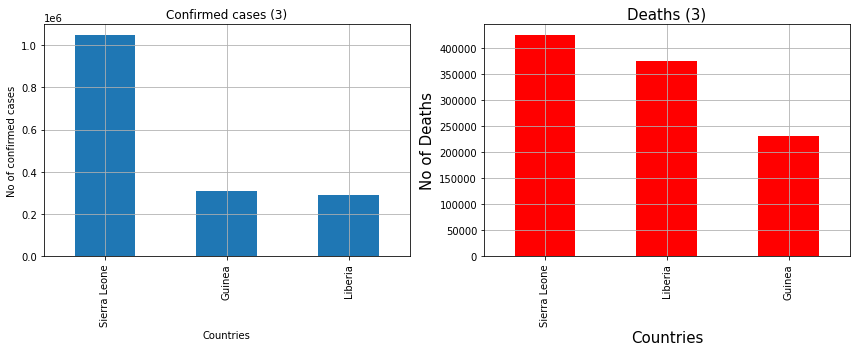

In [28]:
# Barcharts showing Countries with the highest number of confirmed cases and highest number of Deaths
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
df_1.groupby('Country')['Confirmed cases'].sum().nlargest(3).plot(kind = 'bar', grid = True)
plt.title('Confirmed cases (3)')
plt.xlabel('Countries')
plt.ylabel('No of confirmed cases')


plt.subplot(1,2,2)
df_1.groupby('Country')['Deaths'].sum().nlargest(3).plot(kind = 'bar', grid = True,
                                                                       color = 'red')
plt.title('Deaths (3)', size=15)
plt.xlabel('Countries', size=15)
plt.ylabel('No of Deaths', size=15)
plt.tight_layout()
plt.show()



In [29]:
#Countries with the top 3 highest number of suspected cases
df_1.groupby('Country')['Suspected Cases'].sum().nlargest(3)

Country
Liberia         301702.0
Sierra Leone    283025.0
Guinea            5542.0
Name: Suspected Cases, dtype: float64

In [30]:
#Countries with the top 3 highest number of Probable cases
df_1.groupby('Country')['Probable cases'].sum().nlargest(3)

Country
Liberia         216041.0
Guinea           42074.5
Sierra Leone     32274.0
Name: Probable cases, dtype: float64

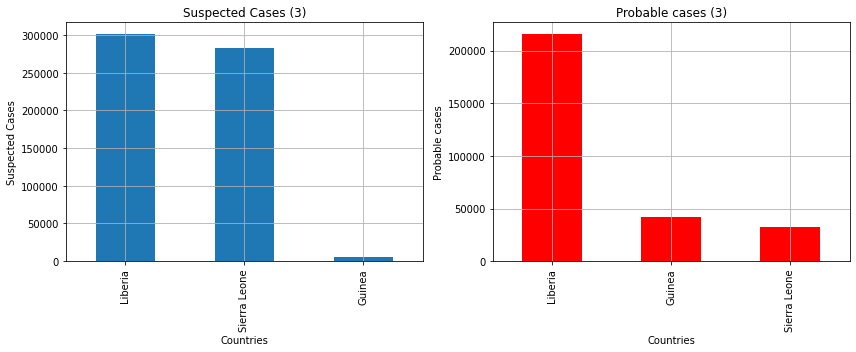

In [31]:
# Barcharts showing Countries with the highest number of Suspected cases and highest number of Probable cases

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df_1.groupby('Country')['Suspected Cases'].sum().nlargest(3).plot(kind = 'bar', grid = True)
plt.title('Suspected Cases (3)')
plt.xlabel('Countries')
plt.ylabel('Suspected Cases')

plt.subplot(1,2,2)
df_1.groupby('Country')['Probable cases'].sum().nlargest(3).plot(kind = 'bar', grid = True,
                                                                       color = 'red')
plt.title('Probable cases (3)')
plt.xlabel('Countries')
plt.ylabel('Probable cases')
plt.tight_layout()
plt.show()

In [32]:
df_1.Country.unique()

array(['Guinea', 'Liberia', 'Sierra Leone', 'Nigeria', 'Senegal', 'Mali'],
      dtype=object)

In [33]:
# Sierra Leone

df_Liberia= df_1[df_1['Country']=='Liberia']
df_Liberia= df_Liberia.groupby('Date')['Cases', 'Deaths', 'Recovered'].sum()
df_Liberia= df_Liberia.reset_index()

df_Liberia['Cases']=df_Liberia['Cases'].abs()
df_Liberia['Recovered']=df_Liberia['Recovered'].abs()
df_Liberia['Deaths']=df_Liberia['Deaths'].abs()

#--------------


fig=px.area(df_Liberia.melt(id_vars='Date',value_vars=['Cases', 'Deaths', 'Recovered']),x='Date',y='value',color='Category',title='Liberia')
fig.show()

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [34]:
# Sierra Leone

df_Sierra= df_1[df_1['Country']=='Sierra Leone']
df_Sierra= df_Sierra.groupby('Date')['Cases', 'Deaths', 'Recovered'].sum()
df_Sierra= df_Sierra.reset_index()

df_Sierra['Cases']=df_Sierra['Cases'].abs()
df_Sierra['Recovered']=df_Sierra['Recovered'].abs()
df_Sierra['Deaths']=df_Sierra['Deaths'].abs()

#--------------------------------------


fig=px.area(df_Sierra.melt(id_vars='Date',value_vars=['Cases', 'Deaths', 'Recovered']),x='Date',y='value',color='Category',title='Sierra Leone')
fig.show()

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [35]:
# Guinea

df_Guinea= df_1[df_1['Country']=='Guinea']
df_Guinea= df_Guinea.groupby('Date')['Cases', 'Deaths', 'Recovered'].sum()
df_Guinea= df_Guinea.reset_index()

df_Guinea['Cases']=df_Guinea['Cases'].abs()
df_Guinea['Recovered']=df_Guinea['Recovered'].abs()
df_Guinea['Deaths']=df_Guinea['Deaths'].abs()

#--------------


fig=px.area(df_Guinea.melt(id_vars='Date',value_vars=['Cases', 'Deaths', 'Recovered']),x='Date',y='value',color='Category',title='Guinea')
fig.show()

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



# Creating the Coropleth

In [36]:
# Creating the Coropleth

fig = go.Figure(data=go.Choropleth(
    locations = df_1['Country'],
    locationmode = 'country names',
    z = df_1['Confirmed cases'],
    colorscale = 'Reds',
    marker_line_color = 'black',
    marker_line_width = 0.5,
))
fig.update_layout(
    title_text = 'Confirmed Cases',
    title_x = 0.5,
    geo=dict(
        showframe = False,
        showcoastlines = False,
    )
)

In [37]:
df_1_total=df_1.groupby('Country')['Cases','Deaths'].sum()
df_1_total=df_1_total.reset_index()

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [38]:
df_1_total

Category,Country,Cases,Deaths
0,Guinea,363349.5,230414.0
1,Liberia,843783.0,375444.0
2,Mali,52.0,42.0
3,Nigeria,460.0,168.0
4,Senegal,19.0,0.0
5,Sierra Leone,1367120.0,424962.0


In [39]:
fig = px.choropleth(df_1_total, locations="Country", locationmode='country names',
                    color="Cases", hover_name="Country", 
                            scope ="africa",
                    color_continuous_scale="dense",
                     labels={'Cases':'Cases'},
                     title={
                         'text': "EBOLA Total Cases",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

In [40]:
fig = px.choropleth(df_1_total, locations="Country", locationmode='country names',
                    color="Deaths", hover_name="Country", 
                            scope ="africa",
                    color_continuous_scale="dense",
                     labels={'Deaths':'Deaths'},
                     title={
                         'text': "EBOLA Total Deaths",
                         'y':0.9,
                         'x':0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

# Now Modeling Ebola Virus Disease Cases using ARIMA Model

In [19]:
df.head()

,Country,Localite,Category,Value,Date
0,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Cases,86.0,2014-03-24
1,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Deaths,59.0,2014-03-24
2,Guinea,"( Guekedou, Macenta and Kissidougou",Cases,86.0,2014-03-25
3,Guinea,"( Guekedou, Macenta and Kissidougou",Deaths,60.0,2014-03-25
4,Guinea,"( Guekedou, Macenta and Kissidougou",Cases,86.0,2014-03-26


In [20]:
list(df.Category.unique())

['Cases',
 'Deaths',
 'Suspected Cases',
 'Confirmed cases',
 'Probable cases',
 'New Cases']

In [21]:
# Here we are selecting 'Guinea' country for modeling EVD especially Confirmed Cases to Farcast future cases.

df_Guinea_cases=df[df.Country=='Guinea'][df.Localite=='National'][df.Category=='Confirmed cases']
df_Guinea_cases=df_Guinea_cases[['Value','Date']].set_index('Date').sort_values(by='Date', ascending=True)
print(df_Guinea_cases.head())

# Here we are selecting 'Guinea' country for modeling EVD especially Confirmed Cases to Farcast future cases.

df_Guinea_deaths=df[df.Country=='Guinea'][df.Localite=='National'][df.Category=='Deaths']
df_Guinea_deaths=df_Guinea_deaths[['Value','Date']].set_index('Date').sort_values(by='Date', ascending=True)
print(df_Guinea_deaths.head())


            Value
Date             
2014-03-31   24.0
2014-04-01   35.0
2014-04-04   54.0
2014-04-11   71.0
2014-04-16  101.0
            Value
Date             
2014-03-31   80.0
2014-04-01   83.0
2014-04-04   86.0
2014-04-07   95.0
2014-04-10  101.0


C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Zeeshan Haleem\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



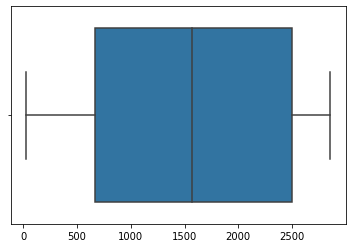

In [22]:
# Plotting boxplot to see any outlier in the Dataset
sns.boxplot(df_Guinea_cases)


In [23]:
indexDataset= df_Guinea_cases.copy()

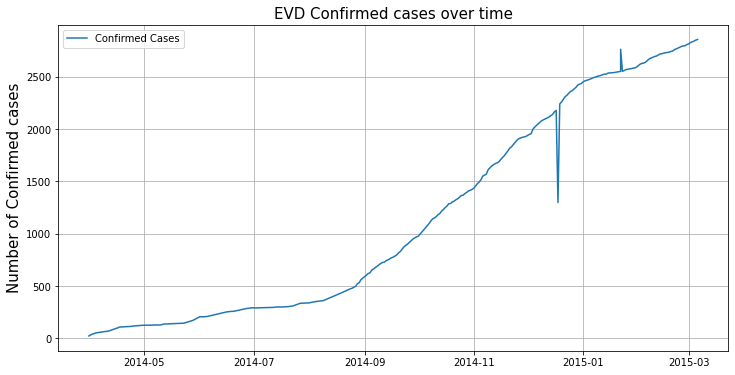

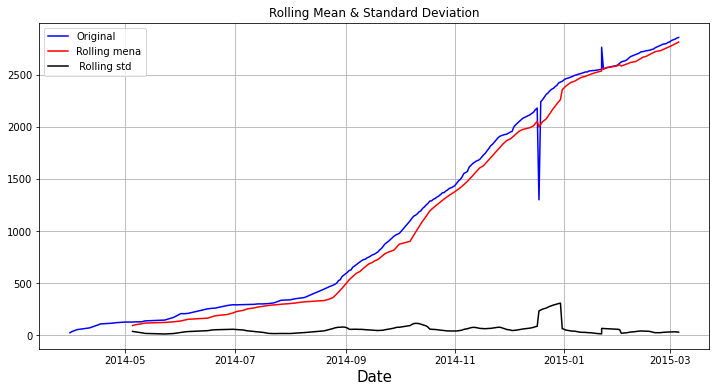

In [24]:
#plot graph.
plt.figure(figsize=(12,6))

plt.ylabel('Number of Confirmed cases',fontsize=15)
plt.title('EVD Confirmed cases over time',fontsize=15)
plt.plot(indexDataset, label='Confirmed Cases')
plt.legend()
plt.grid()


# Determining rolling statistics
rolmean = indexDataset.rolling(window=12).mean()
rolstd = indexDataset.rolling(window=12).std()
# print(rolmean,rolstd)

# Plot rolling statistics

plt.figure( figsize=(12,6))
orig= plt.plot(indexDataset, color='blue',label='Original')
mean= plt.plot(rolmean, color='red',label='Rolling mena')
std= plt.plot(rolstd, color='black', label=' Rolling std')
plt.legend(loc='best')
plt.xlabel('Date',fontsize=15)
plt.grid()
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Spliting Dataset into training and testing

In [25]:
train= indexDataset.iloc[:-60]
test= indexDataset.iloc[-60:]

print(train.shape)
print(test.shape)

(150, 1)
(60, 1)


In [48]:
# Perform Dickey Fuller test : method-1
from statsmodels.tsa.stattools import adfuller
print('Result of Dickey-Fuller Test :')
dftest= adfuller(indexDataset['Value'],autolag='AIC')

dfoutput= pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags Used','Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key]= value

print(dfoutput)    


#---------------------------------------------------------------
# # Perform Dickey Fuller test : method-2
# from statsmodels.tsa.stattools import adfuller

# def ad_test(dataset):
#     dftest=adfuller(dataset, autolag='AIC')
#     print("1.ADF :", dftest[0])
#     print("2.P-Value :", dftest[1])
#     print("3.Num of Lags :", dftest[2])
#     print("4.Number of observations used for ADF Regressiomn and Critical value calculation :", dftest[3])
#     print("5. Critical Values :")
#     for key, val in dftest[4].items():
#         print("\t", key, ":", val)   

# ad_test(indexDataset['Value'])
    

Result of Dickey-Fuller Test :
Test Statistics                 -0.973821
p-value                          0.762692
#Lags Used                       5.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


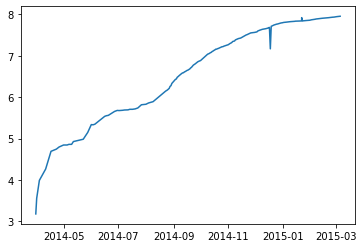

In [49]:
# Now taking log

df_log= np.log(indexDataset)
plt.plot(df_log)

In [50]:
# Let's create a function which determine wheather a the given time series is stationary

def check_stationarity(dataset):
    
    # rolling statistics
    rolling_mean = dataset.rolling(window=2).mean()
    rollingh_std = dataset.rolling(window=2).std()
    
    # rolling plot
    original =plt.plot(dataset, color='blue', label='Original')
    mean= plt.plot( rolling_mean, color='red', label='Rolling Mean')
    std= plt.plot(rollingh_std, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std Deviation')
    plt.grid()
    plt.show(block=False)
    
    # Dickey-Fuller test:
    result= adfuller( dataset['Value'])
    print('ADF Statistics:{}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('# Lag Used: {}'.format(result[2]))
    print('Critical Values:')
    
    for key, value in result[4].items():
        print('\t{}:{}'.format(key, value))

    


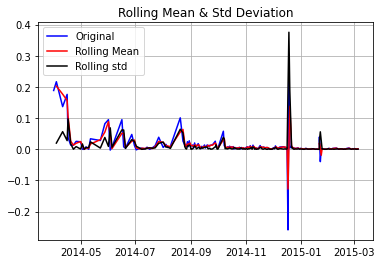

ADF Statistics:-3.2164691690228784
p-value: 0.019050952887644586
# Lag Used: 15
Critical Values:
	1%:-3.4646940755442612
	5%:-2.8766348847254934
	10%:-2.5748163958763994


In [51]:
rolling_mean=df_log.rolling(window=2).mean()
df_log_minus_mean = df_log-rolling_mean
df_log_minus_mean.dropna(inplace=True)

check_stationarity(df_log_minus_mean)

In [52]:
# # Now applying Exponential decay method to check stationarity

# rolling_mean_exp_decay = df_log.ewm(halflife=2, min_periods=0, adjust=True).mean()
# df_log_exp_decay= df_log- rolling_mean_exp_decay

# df_log_exp_decay.dropna(inplace=True)

# check_stationarity(df_log_exp_decay)

#-----------------------------------------------------------
## Now applying time shifting method to check stationarity

# df_log_shift= df_log- df_log.shift()
# df_log_shift.dropna(inplace=True)

# check_stationarity(df_log_shift)



In [53]:
df_log_minus_mean.head()

,Value
Date,
2014-04-01,0.188647
2014-04-04,0.216818
2014-04-11,0.136848
2014-04-16,0.176220
2014-04-17,0.038114


In [54]:
# Figure out Order for ARIMA Model using auto-arima

from pmdarima import auto_arima
# ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [55]:
stepwise_fit = auto_arima(indexDataset['Value'], trace= True, suppress_warnings=True)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=2406.641, BIC=2426.695, Time=0.329 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2488.865, BIC=2495.549, Time=0.013 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2435.235, BIC=2445.262, Time=0.059 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2400.786, BIC=2410.813, Time=0.121 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2491.315, BIC=2494.658, Time=0.012 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2402.603, BIC=2415.972, Time=0.212 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=2402.592, BIC=2415.961, Time=0.186 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=2404.577, BIC=2421.289, Time=0.346 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Total fit time: 1.286 seconds


In [56]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1197.393
Date:                Tue, 08 Dec 2020   AIC                           2400.786
Time:                        09:58:57   BIC                           2410.813
Sample:                             0   HQIC                          2404.840
                                - 210                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     13.6153      2.587      5.262      0.000       8.544      18.687
ma.L1         -0.7123      0.026    -26.999      0.000      -0.764      -0.661
sigma2      5525.3064    155.431     35.548      0.000    5220.668    5829.945
===================================================================================
Ljung-Box (Q):                       11.61   Jarque-Bera (JB):             72810.93
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.12   Skew:                            -7.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        93.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
indexDataset.shape

(210, 1)

In [58]:
# Now Modeling
from statsmodels.tsa.arima_model import ARIMA

print(indexDataset.shape)
train=indexDataset.iloc[:-60]
test=indexDataset.iloc[-60:]

print(train.shape, test.shape)


(210, 1)
(150, 1) (60, 1)


In [59]:
# Train the Model

model= ARIMA( train['Value'], order=(0,1,1))
model_fit= model.fit()
model_fit.summary()

# Now forcasting
model_forcast= model_fit.forecast(steps=60)[0]


In [60]:
# Now Ckecking the accuracy of ARIMA model
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse= sqrt(mean_squared_error(model_forcast, test['Value']))
print(rmse)

336.4044866655962


In [61]:
# Now Converting forcatsted values into dataframe
model_forcast=pd.DataFrame(model_forcast, index=test.index)

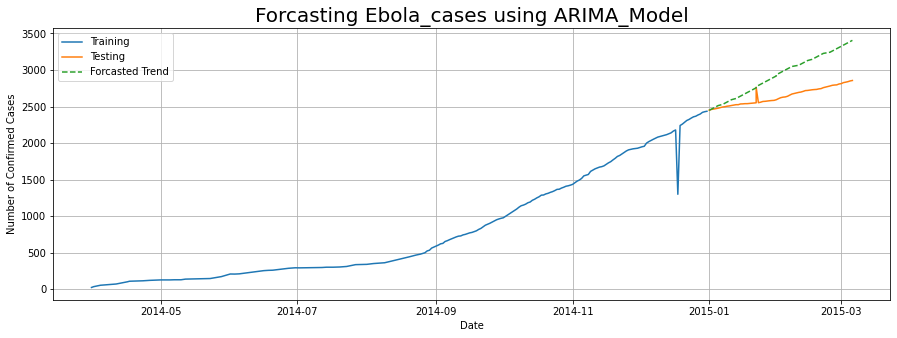

In [62]:
# Plotting the graph between traing, testing and Forcasted values

plt.figure(figsize=(15,5))
plt.plot(train, label='Training')

plt.plot(test, label='Testing')
plt.plot(model_forcast, label='Forcasted Trend',linestyle='dashed')
plt.title('Forcasting Ebola_cases using ARIMA_Model',fontdict={'fontsize':20,'fontweight' :1})
plt.xlabel('Date',fontdict={'fontsize':10,'fontweight' :1})
plt.ylabel('Number of Confirmed Cases',fontdict={'fontsize':10,'fontweight' :1})

plt.legend()
plt.grid()



### Now we have to mannualy find p,d,q values by running loop and look minimum AIC among all given AICs. 

In [45]:
import warnings
warnings.filterwarnings('ignore')

import itertools
p=d=q=range(0,3)
pdq= list(itertools.product(p,d,q))

aic_list=dict()

for pm in pdq:
    try:
        model= ARIMA(indexDataset['Value'],order=pm)
        model_fit= model.fit()
        AIC= model_fit.aic
        aic_list.update({pm:AIC})
        print("ARIMA %s AIC= %.2f" %(pm, AIC))
    except:
        continue
        
df_aic= pd.DataFrame({'pm':aic_list.keys(),'AIC':aic_list.values()})        
        

ARIMA (0, 0, 0) AIC= 3468.72
ARIMA (0, 0, 1) AIC= 3223.33
ARIMA (0, 0, 2) AIC= 3051.73
ARIMA (0, 1, 0) AIC= 2488.86
ARIMA (0, 1, 1) AIC= 2400.79
ARIMA (0, 1, 2) AIC= 2402.59
ARIMA (0, 2, 0) AIC= 2704.31
ARIMA (0, 2, 1) AIC= 2485.25
ARIMA (0, 2, 2) AIC= 2397.68
ARIMA (1, 0, 0) AIC= 2512.28
ARIMA (1, 0, 1) AIC= 2458.07
ARIMA (1, 0, 2) AIC= 2457.58
ARIMA (1, 1, 0) AIC= 2435.24
ARIMA (1, 1, 1) AIC= 2402.61
ARIMA (1, 1, 2) AIC= 2402.86
ARIMA (1, 2, 0) AIC= 2584.05
ARIMA (2, 0, 0) AIC= 2466.71
ARIMA (2, 0, 1) AIC= 2458.15
ARIMA (2, 0, 2) AIC= 2469.42
ARIMA (2, 1, 0) AIC= 2419.25
ARIMA (2, 1, 1) AIC= 2404.52
ARIMA (2, 1, 2) AIC= 2404.85
ARIMA (2, 2, 0) AIC= 2530.88


In [49]:
df_aic.sort_values(by='AIC')[:7]     # Here we have minimum AICs, now we can  check the model accuracy by choosing order one by one

,pm,AIC
8,"(0, 2, 2)",2397.680272
4,"(0, 1, 1)",2400.788781
5,"(0, 1, 2)",2402.594611
13,"(1, 1, 1)",2402.605779
14,"(1, 1, 2)",2402.859276
20,"(2, 1, 1)",2404.521278
21,"(2, 1, 2)",2404.854232


In [62]:
# Now Modeling
from statsmodels.tsa.arima_model import ARIMA

print(indexDataset.shape)
train=indexDataset.iloc[:-60]
test=indexDataset.iloc[-60:]

print(train.shape, test.shape)

# Train the Model

model= ARIMA( train['Value'], order=(2,1,1))
model_fit= model.fit()
model_fit.summary()

# Now forcasting
model_forcast= model_fit.forecast(steps=60)[0]

# Now Converting forcatsted values into dataframe
model_forcast=pd.DataFrame(model_forcast, index=test.index)



(210, 1)
(150, 1) (60, 1)


In [63]:
# Now Ckecking the accuracy of ARIMA model
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse= sqrt(mean_squared_error(model_forcast, test['Value']))
print(rmse)

335.74193189658916


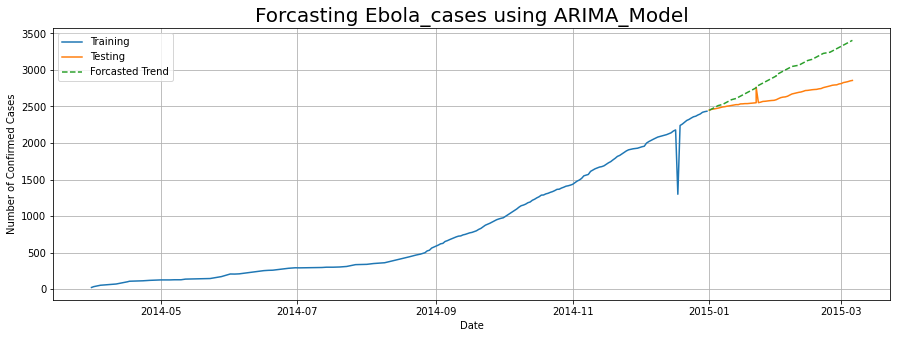

In [64]:
# Plotting the graph between traing, testing and Forcasted values

plt.figure(figsize=(15,5))
plt.plot(train, label='Training')

plt.plot(test, label='Testing')
plt.plot(model_forcast, label='Forcasted Trend',linestyle='dashed')
plt.title('Forcasting Ebola_cases using ARIMA_Model',fontdict={'fontsize':20,'fontweight' :1})
plt.xlabel('Date',fontdict={'fontsize':10,'fontweight' :1})
plt.ylabel('Number of Confirmed Cases',fontdict={'fontsize':10,'fontweight' :1})

plt.legend()
plt.grid()


# Now Applying SVR Machine Learning Model to predict the Ebola Virus

In [63]:
# Importing SVR libraries

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [64]:
df_Guinea_cases=df_Guinea_cases.reset_index()
print(df_Guinea_cases)


          Date   Value
0   2014-03-31    24.0
1   2014-04-01    35.0
2   2014-04-04    54.0
3   2014-04-11    71.0
4   2014-04-16   101.0
..         ...     ...
205 2015-03-02  2827.0
206 2015-03-03  2833.0
207 2015-03-04  2840.0
208 2015-03-05  2850.0
209 2015-03-06  2856.0

[210 rows x 2 columns]


In [65]:
df_Guinea_cases['No_of_Days']=df_Guinea_cases.index.values+1

In [66]:
df_Guinea_cases

,Date,Value,No_of_Days
0,2014-03-31,24.0,1
1,2014-04-01,35.0,2
2,2014-04-04,54.0,3
3,2014-04-11,71.0,4
4,2014-04-16,101.0,5
...,...,...,...
205,2015-03-02,2827.0,206
206,2015-03-03,2833.0,207
207,2015-03-04,2840.0,208
208,2015-03-05,2850.0,209


In [67]:
Days=[]
Confirmed_cases =[]


# Now Creating independent Dataset for Days

for day in df_Guinea_cases.No_of_Days:
    Days.append(day)
    
# Now Creating independent Dataset for Confirmed Cases

for case in df_Guinea_cases.Value:
    Confirmed_cases.append(case)

In [68]:
# Reshaping Days & Confirmed cases
Days= np.array(Days).reshape(-1,1)
Confirmed_cases=np.array(Confirmed_cases).reshape(-1,1)

In [69]:
X= Days
y=Confirmed_cases

# Feature Scaling

In [70]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)


In [71]:
# Training the SVR model on the whole dataset

from sklearn.svm import SVR

# Model1
regressor1= SVR(kernel='rbf')
regressor1.fit(X,y)

# Model2
regressor2= SVR(kernel='poly',C=1e3, degree=3)
regressor2.fit(X,y)


SVR(C=1000.0, kernel='poly')

In [72]:
# Checking Mean_absulut_error and Mean_squared_error
# mean_squared_error(test_value, predicted_value)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from  sklearn.metrics import accuracy_score

MAE=mean_absolute_error(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor1.predict(X)))
MSE=mean_squared_error(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor1.predict(X)))

print(" MAE :", MAE)
print("MSE :", MSE)
print('RMSE :', np.sqrt(MSE))

 MAE : 46.840222426624116
MSE : 6273.845861974491
RMSE : 79.20761239915322


# Plotting SVR Machine Learning Model

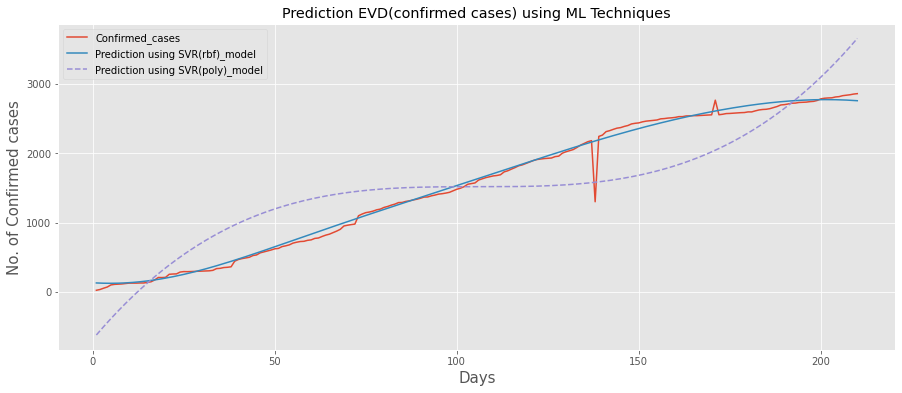

In [73]:
plt.style.use('ggplot')
plt.figure(figsize=(15,6))
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(y), label='Confirmed_cases')
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor1.predict(X)), label='Prediction using SVR(rbf)_model' )
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor2.predict(X)), linestyle='dashed', label='Prediction using SVR(poly)_model' )

plt.title('Prediction EVD(confirmed cases) using ML Techniques')
plt.xlabel('Days', size=15)
plt.ylabel('No. of Confirmed cases', size=15)

plt.legend()

# Now Prediction for Death over time using SVR ML model

In [74]:
df_Guinea_deaths=df_Guinea_deaths.reset_index()

df_Guinea_deaths['No_of_Days']=df_Guinea_deaths.index.values+1


#-----------------------------------------
Days=[]
Deaths =[]

# Now Creating independent Dataset for Days

for day in df_Guinea_deaths.No_of_Days:
    Days.append(day)
    
# Now Creating independent Dataset for Confirmed Cases

for death in df_Guinea_deaths.Value:
    Deaths.append(death)
#--------------------------------------------------------    
# Reshaping Days & Confirmed cases
Days= np.array(Days).reshape(-1,1)
Deaths=np.array(Deaths).reshape(-1,1)

#-----------------------------
X= Days
y=Deaths

#-----------------------------------------------------------------

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
#--------------------------------------------------
# Training the SVR model on the whole dataset

from sklearn.svm import SVR

# Model1
regressor1= SVR(kernel='rbf')
regressor1.fit(X,y)

# Model2
regressor2= SVR(kernel='poly')
regressor2.fit(X,y)


SVR(kernel='poly')

In [75]:
# Checking Mean_absulut_error and Mean_squared_error
# mean_squared_error(test_value, predicted_value)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from  sklearn.metrics import accuracy_score

MAE=mean_absolute_error(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor1.predict(X)))
MSE=mean_squared_error(sc_y.inverse_transform(y),sc_y.inverse_transform(regressor1.predict(X)))

print(" MAE :", MAE)
print("MSE :", MSE)
print('RMSE :', np.sqrt(MSE))




 MAE : 28.122669740996837
MSE : 1312.348868555976
RMSE : 36.226355993336895


# Visualization of Death predictions in Guinea using SVR ML Model

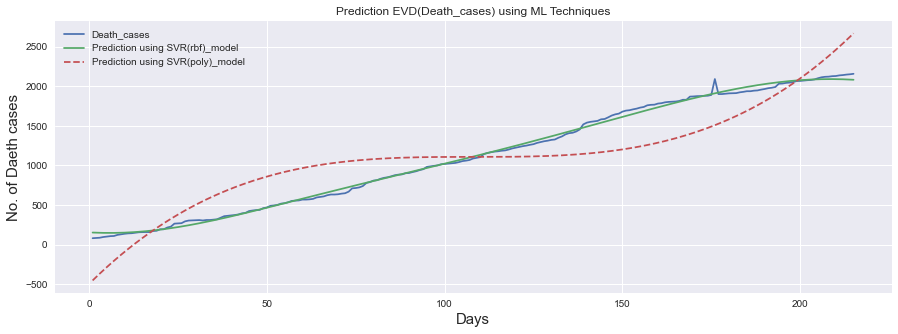

In [76]:
#-----------------------------------------------------
#------- now plotting -----------------------------------
plt.style.use('seaborn')
plt.figure(figsize=(15,5))
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(y), label='Death_cases')
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor1.predict(X)), label='Prediction using SVR(rbf)_model' )
plt.plot(sc_X.inverse_transform(X),sc_y.inverse_transform(regressor2.predict(X)), linestyle='dashed', label='Prediction using SVR(poly)_model' )

plt.title('Prediction EVD(Death_cases) using ML Techniques')
plt.xlabel('Days', size=15)
plt.ylabel('No. of Daeth cases', size=15)

plt.legend()

#--------------------------------------------------